# Skin Lesion Classification using Deep Learning

If you're using Tinder, all the necessary requirements are already installed in a conda environment.

To activate the environment in the terminal, use the command: ```conda activate env```

## Accessing TensorBoard:

1. Navigate to the TensorBoard logs directory:
    ```cd skin_lesion_classification/logs```

2. Start TensorBoard:
    ```tensorboard --logdir ./ --bind_all```

3. ctrl + click on the TensorBoard link.

Run the cell below if you haven't installed the requirements on your machine yet.

In [56]:
# !pip install -r requirements.txt


## Importing all the libraries

In [57]:

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

import pytorch_lightning
import torchvision.models as models
import torchvision.transforms as transforms
from pytorch_lightning.loggers import TensorBoardLogger

from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from efficientnet_pytorch import EfficientNet

from PIL import Image
import pandas as pd
import os

import numpy as np
import random
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

## Set seeds for reproducibility

In [58]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Loading CSV

In [59]:

class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir_1, root_dir_2, transform):
        self.annotations = pd.read_csv(csv_file)                         # Path to the CSV file containing data information.
        self.root_dir_1 = root_dir_1                                     # Path to the first directory where images are stored.
        self.root_dir_2 = root_dir_2                                     # Path to the second directory where images are stored.
        self.transform = transform                                       # Transformations to be applied to the images.
    
    def __len__(self):
        return len(self.annotations)                                     # Return the number of samples in the dataset.
    
    def __getitem__(self, idx):
        img_code = self.annotations.iloc[idx, 1]                         # Extract the file code from the DataFrame
        img_name = img_code + '.jpg'                                     # Add the '.jpg' extension
        img_path = None

        # Check if image is in directory 1
        if os.path.exists(os.path.join(self.root_dir_1, img_name)):
            img_path = os.path.join(self.root_dir_1, img_name)

        # Check if image is in directory 2
        elif os.path.exists(os.path.join(self.root_dir_2, img_name)):
            img_path = os.path.join(self.root_dir_2, img_name)
        
        # Print an error message if image is not found in either directory
        if img_path is None:
            print("IDX ",idx )
            print(f"File {img_name} not found in any of the specified directories.")
            return None, None  # Return None for image and label

        # Open the image and convert to RGB if found
        # This operation is included as a precaution to ensure all images are treated consistently
        image = Image.open(img_path).convert('RGB')

        label = self.annotations.iloc[idx, 2]                              # Access the value in row idx and column 2                
        
        if label == 0:                                                     
            label = torch.tensor(0)                                        # Convert to a tensor with value 0 
        else:
            label = torch.tensor(1)                                        # Convert to a tensor with value 1
            
        if self.transform:
            image = self.transform(image)                                  # Apply transformations
            
        return image, label


# Load CSV file and define paths
csv_file = '/home/ashiley/HAM10000_metadata_alterado.csv'
data_path_1 = '/home/ashiley/HAM10000_images_part_1'
data_path_2 = '/home/ashiley/HAM10000_images_part_2'

# Define transformations
transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])

# Create custom dataset instance
custom_dataset = CustomDataset(csv_file=csv_file, root_dir_1=data_path_1, root_dir_2=data_path_2, transform=transform)

# Create a DataLoader to load data in batches during training.
data_loader = DataLoader(custom_dataset, batch_size=32, shuffle=True)

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

if cuda_available:
    # Get the number of available CUDA devices
    num_cuda_devices = torch.cuda.device_count()
    print("CUDA is available and {} CUDA device(s) is(are) available.".format(num_cuda_devices))
else:
    print("CUDA is not available. You are running on CPU.")

# Move a tensor to the GPU if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Concatenate datasets
full_dataset = custom_dataset

CUDA is available and 2 CUDA device(s) is(are) available.


In [60]:
# Ensure reproducibility for the dataset split
generator = torch.Generator().manual_seed(seed)

total_size = len(full_dataset)
train_size = int(0.8 * total_size)              # 80% for training
val_size = int(0.1 * total_size)                # 10% for validation
test_size = total_size - train_size - val_size  # Remaining 10% for testing

# Split the dataset into training, validation, and test sets
train_dataset, val_dataset, test_dataset = random_split(full_dataset, [train_size, val_size, test_size], generator=generator)

# Create DataLoaders for the training, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)


# Define

In [61]:
input_channels = 3  # Number of channels in the input images (RGB)
num_classes = 2     # Number of classes in the classification task (malignant or benign)


# Train

In [62]:
def train_model(model_class, num_classes, name):
    # Instantiate the model
    model = model_class(num_classes)
    
    early_stop_callback = EarlyStopping(monitor='val_acc', patience=3, mode='max')
    checkpoint_callback = ModelCheckpoint(monitor='val_acc', mode='max')
    
    # Instantiate the trainer
    trainer = pl.Trainer(
        max_epochs=10, 
        accelerator='cuda' if cuda_available else 'cpu',  # Use 'cuda' for GPU and 'cpu' otherwise
        logger=TensorBoardLogger("logs", name=name),
        callbacks=[checkpoint_callback, early_stop_callback]
    )
    
    # Train the model
    trainer.fit(model=model,
                train_dataloaders=train_dataloader,
                val_dataloaders=val_dataloader)
    
    trainer.test(model, test_dataloader)
    
    # Compute confusion matrix, precision, recall, F1-score
    val_confusion = confusion_matrix(model.val_true, [np.argmax(p) for p in model.val_probs])
    test_confusion = confusion_matrix(model.test_true, [np.argmax(p) for p in model.test_probs])
    
    val_precision = precision_score(model.val_true, [np.argmax(p) for p in model.val_probs], average='macro')
    test_precision = precision_score(model.test_true, [np.argmax(p) for p in model.test_probs], average='macro')
    
    val_recall = recall_score(model.val_true, [np.argmax(p) for p in model.val_probs], average='macro')
    test_recall = recall_score(model.test_true, [np.argmax(p) for p in model.test_probs], average='macro')
    
    val_f1 = f1_score(model.val_true, [np.argmax(p) for p in model.val_probs], average='macro')
    test_f1 = f1_score(model.test_true, [np.argmax(p) for p in model.test_probs], average='macro')
    
    print("Validation Confusion Matrix:\n", val_confusion)
    print("Test Confusion Matrix:\n", test_confusion)
    print("Validation Precision: ", val_precision)
    print("Test Precision: ", test_precision)
    print("Validation Recall: ", val_recall)
    print("Test Recall: ", test_recall)
    print("Validation F1-Score: ", val_f1)
    print("Test F1-Score: ", test_f1)
    
    # Plotting metrics
    metrics = {
        'Precision': [val_precision, test_precision],
        'Recall': [val_recall, test_recall],
        'F1-Score': [val_f1, test_f1]
    }
    
    metrics_df = pd.DataFrame(metrics, index=['Validation', 'Test'])
    
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    sns.heatmap(val_confusion, annot=True, fmt='d', cmap='Blues', ax=axes[0])
    axes[0].set_title('Validation Confusion Matrix')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')
    
    sns.heatmap(test_confusion, annot=True, fmt='d', cmap='Blues', ax=axes[1])
    axes[1].set_title('Test Confusion Matrix')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('True')
    
    plt.figure(figsize=(10, 5))
    sns.barplot(data=metrics_df)
    plt.title('Metrics Comparison')
    plt.ylabel('Score')
    
    plt.show()


# Models


# VGG

In [63]:
class VGGClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(VGGClassifier, self).__init__()
        
        # Load the pretrained VGG16 model
        self.vgg16 = models.vgg16(pretrained=True)
        
        # Freeze all layers except the last one
        for param in self.vgg16.parameters():
            param.requires_grad = False
        
        # Unfreeze the last layer
        for param in self.vgg16.classifier[6].parameters():
            param.requires_grad = True
            
        # Modify the classifier layer for the specified number of classes
        num_features = self.vgg16.classifier[6].in_features
        self.vgg16.classifier[6] = nn.Linear(num_features, num_classes)
    
    # Initialize lists to store predictions and true labels
        self.val_preds = []
        self.val_true = []
        self.test_preds = []
        self.test_true = []
        
    def forward(self, x):
        return self.vgg16(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        
        # Add a scheduler
        scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

        return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val_loss'  
        }

    def training_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.val_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.val_true.extend(y.detach().cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).    
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.  
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.test_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.test_true.extend(y.detach().cpu().numpy())
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_validation_epoch_start(self):
        self.val_probs = []
        self.val_true = []

    def on_test_epoch_start(self):
        self.test_probs = []
        self.test_true = []
        
vgg_model = VGGClassifier(num_classes)
print(vgg_model)

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGGClassifier(
  (vgg16): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      

# ResNet

In [64]:
class ResNetClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(ResNetClassifier, self).__init__()
        
        # Load a pre-trained ResNet model
        self.resnet = models.resnet18(pretrained=True)
        
        # Freeze all layers except the last one
        for param in self.resnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last layer
        for param in self.resnet.fc.parameters(): 
            param.requires_grad = True
        
        # Modify the classifier layer for the specified number of classes
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_features, num_classes)
    
    # Initialize lists to store predictions and true labels
        self.val_preds = []
        self.val_true = []
        self.test_preds = []
        self.test_true = []

    def forward(self, x):
        return self.resnet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    
        # Add a scheduler
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
        return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val_loss'  
        }

    def training_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
                    
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).     
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.val_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.val_true.extend(y.detach().cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.test_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.test_true.extend(y.detach().cpu().numpy())
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_validation_epoch_start(self):
        self.val_probs = []
        self.val_true = []

    def on_test_epoch_start(self):
        self.test_probs = []
        self.test_true = []
        
resnet_model = models.resnet18(num_classes=num_classes)
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# AlexNet

In [65]:
class AlexNetClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(AlexNetClassifier, self).__init__()
        
        # Load a pre-trained AlexNet model
        self.alexnet = models.alexnet(pretrained=True)
        
        # Freeze all layers except the last one
        for param in self.alexnet.parameters():
            param.requires_grad = False
        
        # Unfreeze the last layer
        for param in self.alexnet.classifier[6].parameters():
            param.requires_grad = True
            
        # Replace the classifier layer for the specified number of classes
        num_features = self.alexnet.classifier[6].in_features
        self.alexnet.classifier[6] = nn.Linear(num_features, num_classes)
        
        # Initialize lists to store predictions and true labels
        self.val_preds = []
        self.val_true = []
        self.test_preds = []
        self.test_true = []
        
    def forward(self, x):
        return self.alexnet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    
        # Add a scheduler
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
        return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val_loss'  
        }


    def training_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.val_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.val_true.extend(y.detach().cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
        

    def test_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.test_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.test_true.extend(y.detach().cpu().numpy())
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)       
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_validation_epoch_start(self):
        self.val_probs = []
        self.val_true = []

    def on_test_epoch_start(self):
        self.test_probs = []
        self.test_true = []
        
alexnet_model = models.alexnet(num_classes=num_classes)
print(alexnet_model)


AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

# EfficientNet

In [66]:
class EfficientNetClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super(EfficientNetClassifier, self).__init__()

        # Load a pre-trained EfficientNet model
        self.efficientnet = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
        
        # Freeze all layers except the last one
        for name, param in self.efficientnet.named_parameters():
            if '_fc' not in name:  
                param.requires_grad = False
        
        # Initialize lists to store predictions and true labels
        self.val_preds = []
        self.val_true = []
        self.test_preds = []
        self.test_true = []
        
    def forward(self, x):
        return self.efficientnet(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    
        # Add a scheduler
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
        return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val_loss'  
        }

    def training_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).               
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y).        
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.val_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.val_true.extend(y.detach().cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)        
        self.log('val_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch                                # batch is a tuple containing the input data (x) and the target labels (y). 
        logits = self(x)                            # pass the input data to the model to get the predicted logits.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss between the model's predictions (logits) and the true labels (y).
        preds = torch.argmax(logits, dim=1)         # get the predicted labels by taking the argmax of the logits.
        acc = torch.sum(preds == y).item() / len(y) # calculate the accuracy by comparing the predicted labels to the true labels.

        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.test_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.test_true.extend(y.detach().cpu().numpy())
        
        self.log('test_loss', loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        
        return loss
    
    def on_validation_epoch_start(self):
        self.val_probs = []
        self.val_true = []

    def on_test_epoch_start(self):
        self.test_probs = []
        self.test_true = []
        
efficientnet_model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)       
print(efficientnet_model)

Loaded pretrained weights for efficientnet-b0
EfficientNet(
  (_conv_stem): Conv2dStaticSamePadding(
    3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
    (static_padding): ZeroPad2d((0, 1, 0, 1))
  )
  (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
  (_blocks): ModuleList(
    (0): MBConvBlock(
      (_depthwise_conv): Conv2dStaticSamePadding(
        32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
        (static_padding): ZeroPad2d((1, 1, 1, 1))
      )
      (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
      (_se_reduce): Conv2dStaticSamePadding(
        32, 8, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_se_expand): Conv2dStaticSamePadding(
        8, 32, kernel_size=(1, 1), stride=(1, 1)
        (static_padding): Identity()
      )
      (_project_conv): Conv2dStaticSamePadding(
        32, 16, kern

# Inception

In [67]:
class InceptionClassifier(pl.LightningModule):
    def __init__(self, num_classes):
        super().__init__()
        
        # Load a pre-trained Inception model
        self.inception = models.inception_v3(pretrained=True)
        
        # Freeze all layers except the last one
        for name, param in self.inception.named_parameters():
            if "fc" not in name:  
                param.requires_grad = False
        
        # Replace the classifier layer for the specified number of classes
        in_features = self.inception.fc.in_features
        self.inception.fc = nn.Linear(in_features, num_classes)
        
        # Initialize lists to store predictions and true labels
        self.val_preds = []
        self.val_true = []
        self.test_preds = []
        self.test_true = []
        
    def forward(self, x):
        return self.inception(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
    
        # Add a scheduler
        scheduler = StepLR(optimizer, step_size=5, gamma=0.1)
        
        return {
                'optimizer': optimizer,
                'lr_scheduler': scheduler,
                'monitor': 'val_loss'  
        }

    def training_step(self, batch, batch_idx):
        x, y = batch                                # batch é uma tupla contendo os dados de entrada (x) e os rótulos verdadeiros (y).               
        logits = self(x).logits                     # passe os dados de entrada para o modelo para obter os logits preditos.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss entre as previsões do modelo (logits) e os rótulos verdadeiros (y).
                     
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch                                # batch é uma tupla contendo os dados de entrada (x) e os rótulos verdadeiros (y).        
        logits = self(x)                            # passe os dados de entrada para o modelo para obter os logits preditos.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss entre as previsões do modelo (logits) e os rótulos verdadeiros (y).
        preds = torch.argmax(logits, dim=1)         # obtenha os rótulos previstos ao tomar o argmax dos logits.
        acc = torch.sum(preds == y).item() / len(y) # calcula a precisão comparando os rótulos previstos com os rótulos verdadeiros.
        
        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.val_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.val_true.extend(y.detach().cpu().numpy())
        
        self.log('val_loss', loss, on_step=False, on_epoch=True)
        self.log('val_acc', acc, on_step=False, on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch                                # batch é uma tupla contendo os dados de entrada (x) e os rótulos verdadeiros (y).
        logits = self(x)                            # passe os dados de entrada para o modelo para obter os logits preditos.
        loss = F.cross_entropy(logits, y)           # cross-entropy loss entre as previsões do modelo (logits) e os rótulos verdadeiros (y).
        preds = torch.argmax(logits, dim=1)         # obtenha os rótulos previstos ao tomar o argmax dos logits.
        acc = torch.sum(preds == y).item() / len(y) # calcula a precisão comparando os rótulos previstos com os rótulos verdadeiros.

        # Armazene logits e rótulos verdadeiros para computar métricas fora do Lightning
        self.test_probs.extend(torch.softmax(logits, dim=1).detach().cpu().numpy())  # Armazene probabilidades
        self.test_true.extend(y.detach().cpu().numpy())
        
        self.log('test_loss', loss, on_step=False, on_epoch=True)
        self.log('test_acc', acc, on_step=False, on_epoch=True)
        
        return loss

    def on_validation_epoch_start(self):
        self.val_probs = []
        self.val_true = []

    def on_test_epoch_start(self):
        self.test_probs = []
        self.test_true = []


Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/VGG_Classifier
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name  | Type | Params
-------------------------------
0 | vgg16 | VGG  | 134 M 
-------------------------------
8.2 K     Trainable params
134 M     Non-trainable params
134 M     Total params
537.075   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 6: 100%|██████████| 124/124 [01:46<00:00,  1.16it/s, v_num=0, train_loss_step=0.346, val_loss=0.382, val_acc=0.821, train_loss_epoch=0.411]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing DataLoader 0: 100%|██████████| 16/16 [00:11<00:00,  1.41it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8259109258651733
        test_loss           0.39488622546195984
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Confusion Matrix:
 [[776  29]
 [148  34]]
Test Confusion Matrix:
 [[771  24]
 [148  45]]
Validation Precision:  0.6897546897546898
Test Precision:  0.7455646496664616
Validation Recall:  0.5753941710463449
Test Recall:  0.6014859712581875
Validation F1-Score:  0.5875898537552673
Test F1-Score:  0.6215806960193111


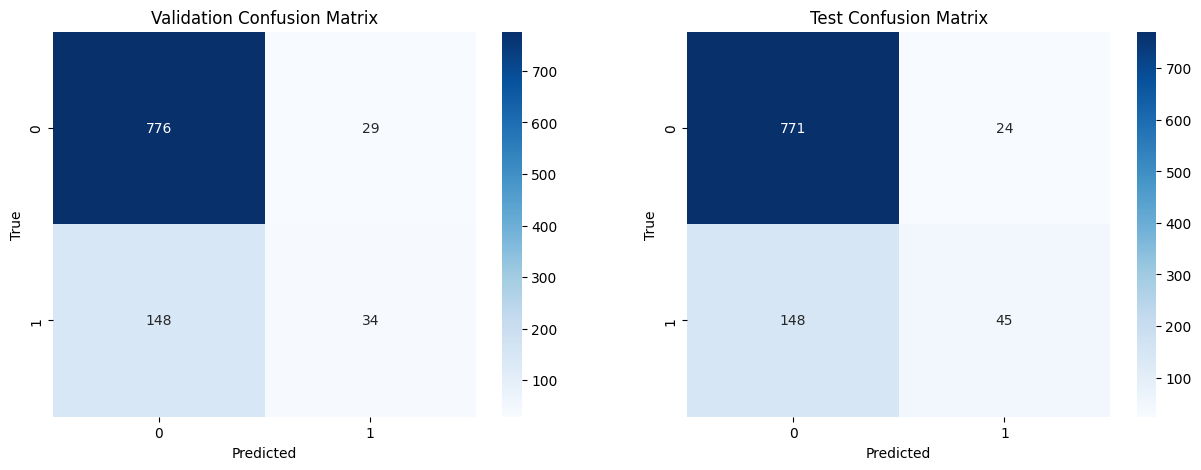

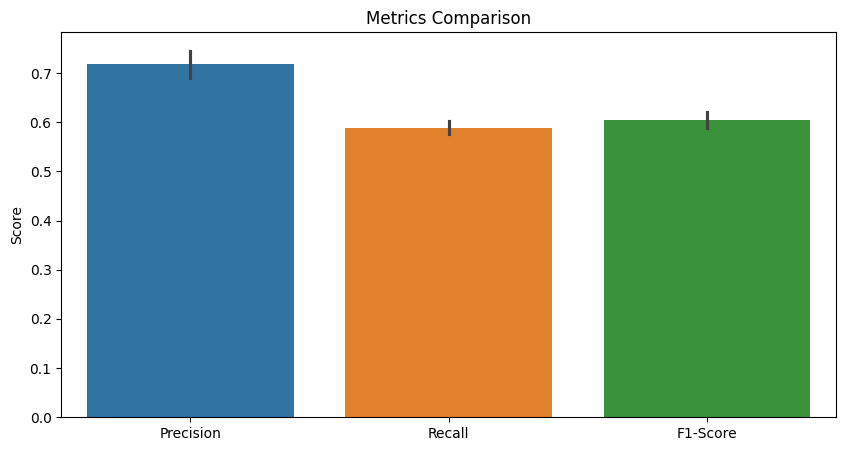

In [68]:
train_model(VGGClassifier, num_classes, 'VGG_Classifier')

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available:

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 8: 100%|██████████| 124/124 [01:14<00:00,  1.67it/s, v_num=1, train_loss_step=0.238, val_loss=0.302, val_acc=0.859, train_loss_epoch=0.316]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 16/16 [00:07<00:00,  2.15it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.862348198890686
        test_loss           0.31297215819358826
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Confusion Matrix:
 [[753  52]
 [ 87  95]]
Test Confusion Matrix:
 [[754  41]
 [ 95  98]]
Validation Precision:  0.771343537414966
Test Precision:  0.7965698112887781
Validation Recall:  0.7286908743430482
Test Recall:  0.7280998468406817
Validation F1-Score:  0.7465045592705168
Test F1-Score:  0.753818192477941


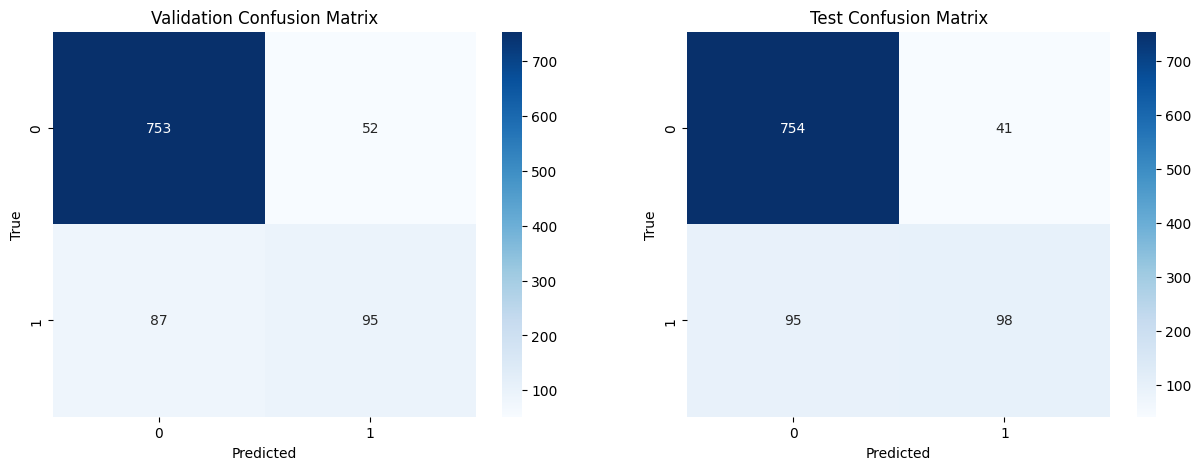

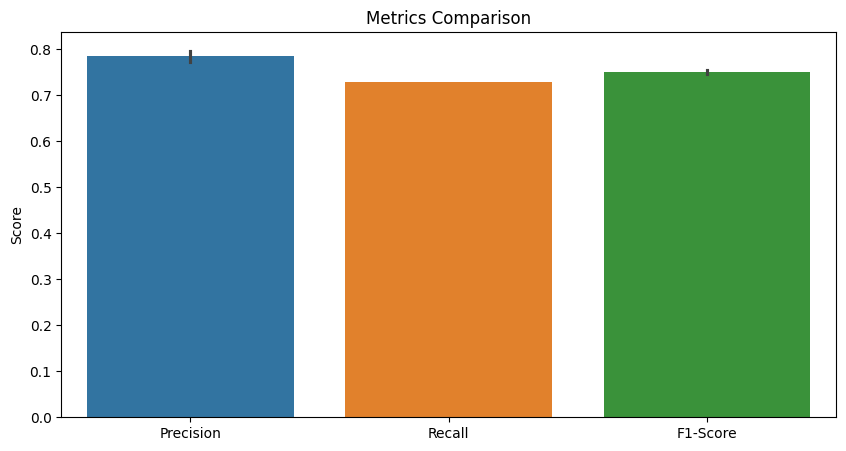

In [69]:
train_model(ResNetClassifier, num_classes, 'ResNet_Classifier')

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: F

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 124/124 [01:06<00:00,  1.87it/s, v_num=0, train_loss_step=0.276, val_loss=0.318, val_acc=0.856, train_loss_epoch=0.354]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 124/124 [01:06<00:00,  1.87it/s, v_num=0, train_loss_step=0.276, val_loss=0.318, val_acc=0.856, train_loss_epoch=0.354]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 16/16 [00:07<00:00,  2.23it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8491902947425842
        test_loss           0.3295254409313202
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Confusion Matrix:
 [[756  49]
 [ 93  89]]
Test Confusion Matrix:
 [[745  50]
 [ 99  94]]
Validation Precision:  0.7676934500947405
Test Precision:  0.7677395997893628
Validation Recall:  0.7140707118967988
Test Recall:  0.712076775181673
Validation F1-Score:  0.7351987605804111
Test F1-Score:  0.7334772052872942


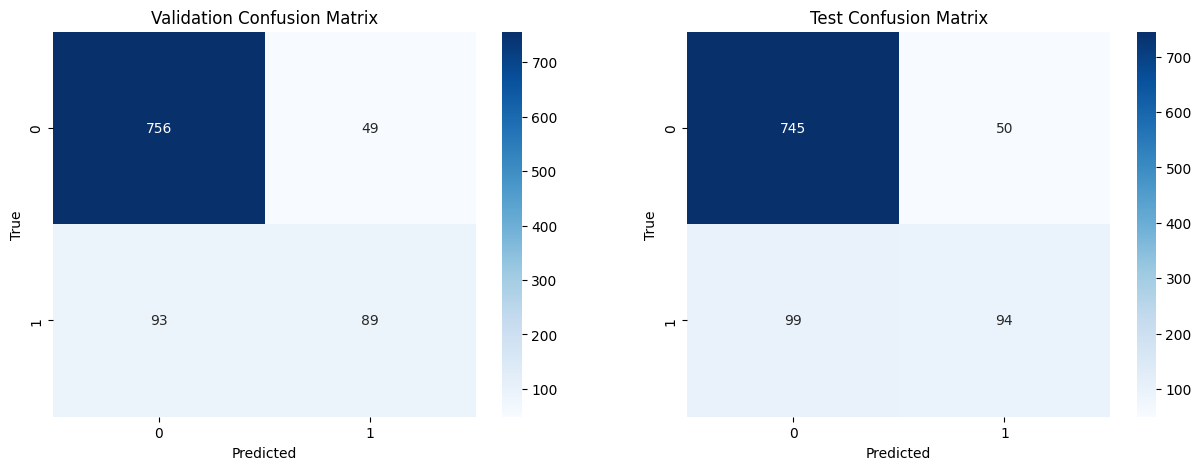

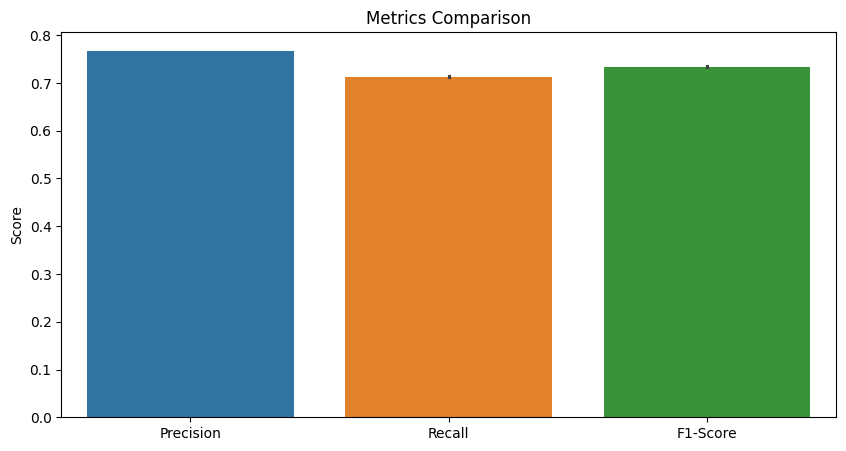

In [70]:
train_model(AlexNetClassifier, num_classes, 'AlexNet_Classifier')

Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name         | Type         | Params
----------------------------------------------
0 | efficientnet | EfficientNet | 4.0 M 
----------------------------------------------
2.6 K     Trainable params
4.0 M     Non-trainable params
4.0 M     Total params
16.040    Total estimated model params size (MB)


Loaded pretrained weights for efficientnet-b0
Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 124/124 [01:27<00:00,  1.42it/s, v_num=2, train_loss_step=0.285, val_loss=0.312, val_acc=0.867, train_loss_epoch=0.327]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 124/124 [01:27<00:00,  1.42it/s, v_num=2, train_loss_step=0.285, val_loss=0.312, val_acc=0.867, train_loss_epoch=0.327]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 16/16 [00:08<00:00,  1.79it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8552631735801697
        test_loss           0.32924649119377136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Confusion Matrix:
 [[763  42]
 [ 89  93]]
Test Confusion Matrix:
 [[746  49]
 [ 94  99]]
Validation Precision:  0.7922143974960876
Test Precision:  0.7785070785070785
Validation Recall:  0.7294075489727663
Test Recall:  0.7256590738749308
Validation F1-Score:  0.7538461245571317
Test F1-Score:  0.7465916937950083


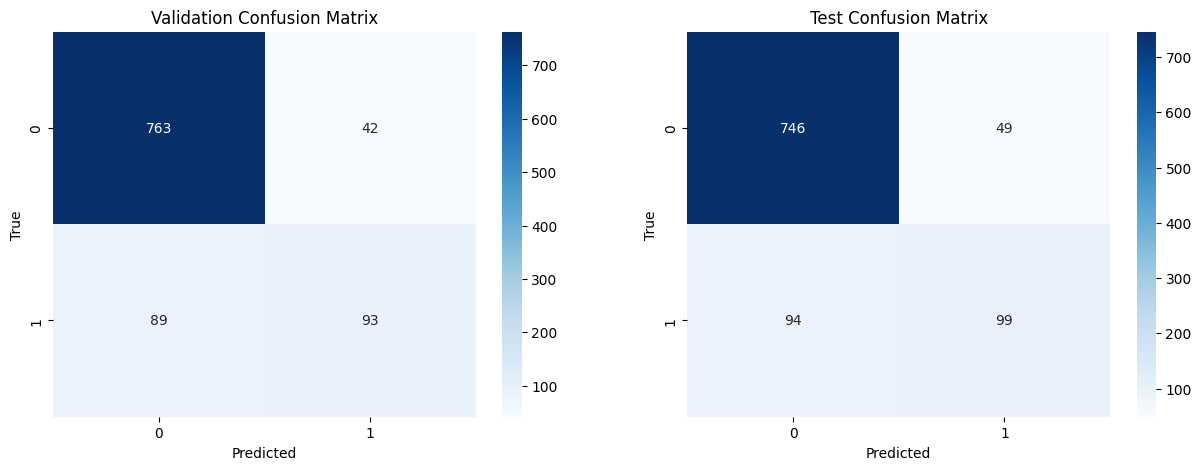

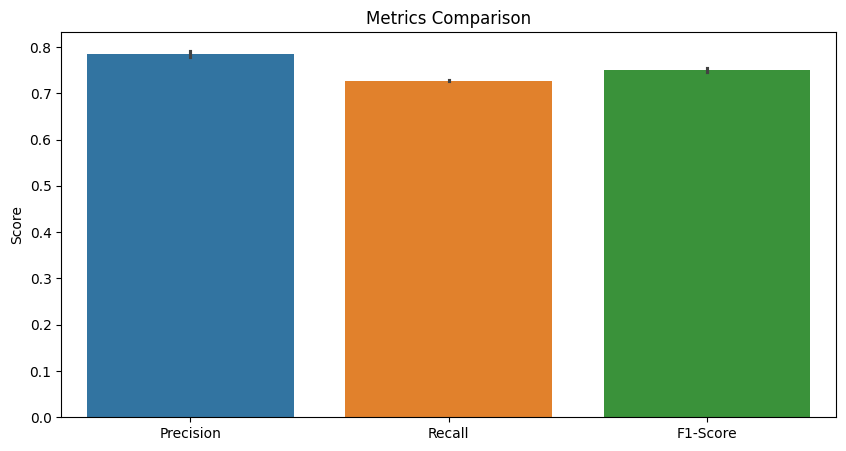

In [71]:
train_model(EfficientNetClassifier, num_classes, 'EfficientNet_Classifier')

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Trainer will use only 1 of 2 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=2)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.
GPU available: True (cuda), used: True
TPU av

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Epoch 7: 100%|██████████| 124/124 [01:24<00:00,  1.46it/s, v_num=16, train_loss_step=0.636, train_loss_epoch=0.371]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
/home/ashiley/miniconda3/envs/env/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.



Testing DataLoader 0: 100%|██████████| 16/16 [00:09<00:00,  1.77it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.840080976486206
        test_loss           0.35483306646347046
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Validation Confusion Matrix:
 [[781  24]
 [121  61]]
Test Confusion Matrix:
 [[772  23]
 [135  58]]
Validation Precision:  0.7917503586800574
Test Precision:  0.7836035226700423
Validation Recall:  0.6526755852842809
Test Recall:  0.6357936585524815
Validation F1-Score:  0.6859922460720232
Test F1-Score:  0.6652628509181985


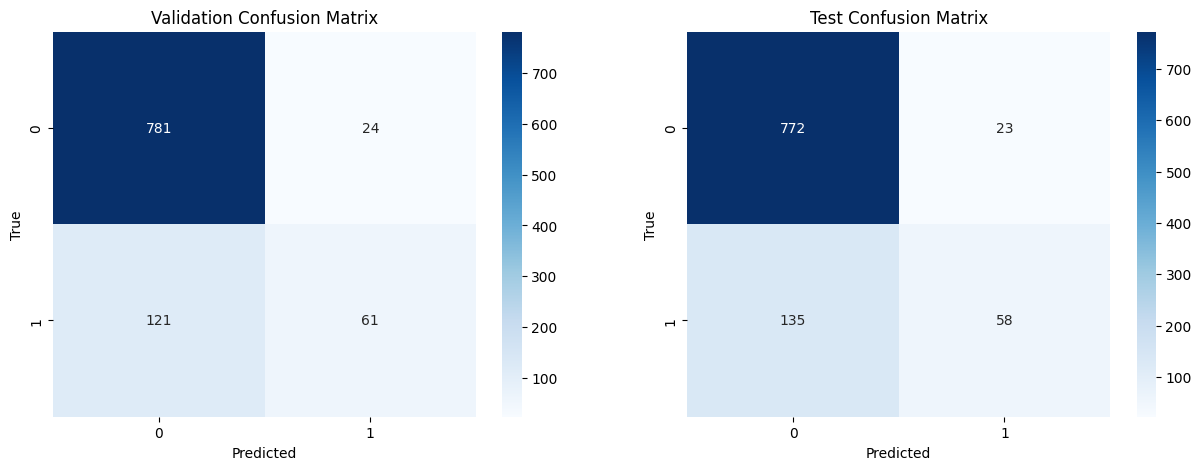

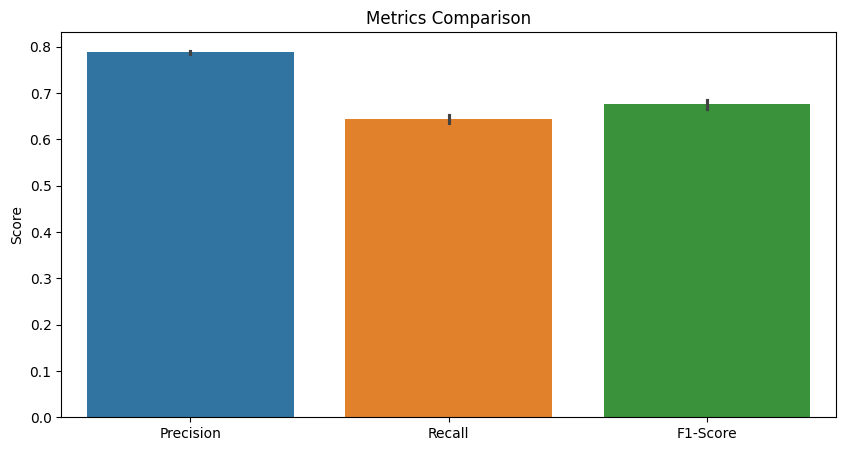

In [72]:
train_model(InceptionClassifier, num_classes, "Inception_Classifier")